In [1]:
import pylab as plt
%matplotlib inline
import numpy as np
import pandas as pd
import math

from featureEngineering2 import feature_engineering

df=pd.read_csv('data/train.csv', sep=',')

df_f = feature_engineering(df)

df_d = feature_engineering(df, get_dummies=True)

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
df_f.head()

,Age_,Age_b,HasAge,Sex,Pclass,Fare_,HasFare,Title_,Embarked_,Cabin_,SibSp_,Parch_
0,22,5,1,male,3,7.250,1,Mr,S,X,1,0
1,38,9,1,female,1,40.000,1,Mrs,C,C,1,0
2,26,6,1,female,3,7.925,1,Miss,S,X,0,0
3,35,9,1,female,1,40.000,1,Mrs,S,C,1,0
4,35,9,1,male,3,8.050,1,Mr,S,X,0,0


In [3]:
df_d.head()

,Age_,Age_b,HasAge,Pclass,Fare_,HasFare,SibSp_,Parch_,Sex_female,Sex_male,...,Embarked__X,Cabin__A,Cabin__B,Cabin__C,Cabin__D,Cabin__E,Cabin__F,Cabin__G,Cabin__T,Cabin__X
0,22,5,1,3,7.250,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,38,9,1,1,40.000,1,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,26,6,1,3,7.925,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,35,9,1,1,40.000,1,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,35,9,1,3,8.050,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [4]:
df_d.columns

Index([u'Age_', u'Age_b', u'HasAge', u'Pclass', u'Fare_', u'HasFare',
       u'SibSp_', u'Parch_', u'Sex_female', u'Sex_male', u'Title__Capt',
       u'Title__Col', u'Title__Don', u'Title__Dr', u'Title__Jonkheer',
       u'Title__Lady', u'Title__Major', u'Title__Master', u'Title__Miss',
       u'Title__Mlle', u'Title__Mme', u'Title__Mr', u'Title__Mrs',
       u'Title__Ms', u'Title__Rev', u'Title__Sir', u'Title__the Countess',
       u'Embarked__C', u'Embarked__Q', u'Embarked__S', u'Embarked__X',
       u'Cabin__A', u'Cabin__B', u'Cabin__C', u'Cabin__D', u'Cabin__E',
       u'Cabin__F', u'Cabin__G', u'Cabin__T', u'Cabin__X'],
      dtype='object')

In [5]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()

X_std = stdsc.fit_transform(df_d)
y_train = df['Survived']

# X_test_std = std.transform(test_df)

In [6]:
X_std 

array([[-0.5924806 , -0.68661155,  0.49789473, ..., -0.06715343,
        -0.03352008,  0.54492498],
       [ 0.63878901,  0.65352183,  0.49789473, ..., -0.06715343,
        -0.03352008, -1.835115  ],
       [-0.2846632 , -0.3515782 ,  0.49789473, ..., -0.06715343,
        -0.03352008,  0.54492498],
       ..., 
       [ 0.        , -0.01654486, -2.0084567 , ..., -0.06715343,
        -0.03352008,  0.54492498],
       [-0.2846632 , -0.3515782 ,  0.49789473, ..., -0.06715343,
        -0.03352008, -1.835115  ],
       [ 0.17706291,  0.31848849,  0.49789473, ..., -0.06715343,
        -0.03352008,  0.54492498]])

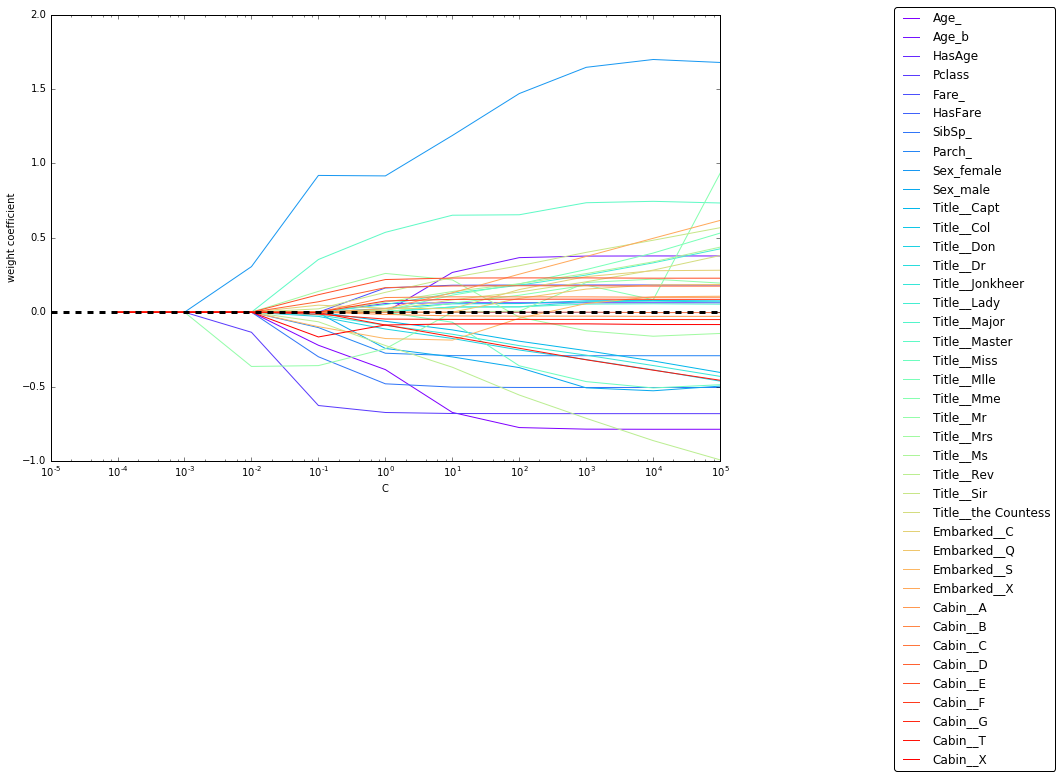

In [7]:
from sklearn.linear_model import LogisticRegression
from matplotlib.pyplot import cm 

fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)

color=iter(cm.rainbow(np.linspace(0,1,X_std.shape[1])))

#plt.plot(x,y,c=color)

weights, params = [], []
for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    lr.fit(X_std, y_train)
    weights.append(lr.coef_[0])
    params.append(10**c)

weights = np.array(weights)

for column in range(weights.shape[1]):
    color_=next(color)
    plt.plot(params, weights[:, column],
             label=df_d.columns[column],
             color=color_)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
# plt.savefig('./figures/l1_path.png', dpi=300)
plt.show()

## Sequential feature selection algorithms

* Greedy algorithm

In [8]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=self.test_size, 
                                 random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

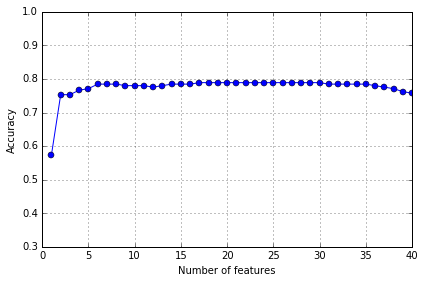

In [9]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.3, 1.0])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [10]:
sbs.scores_

[0.75784753363228696,
 0.7623318385650224,
 0.77130044843049328,
 0.77578475336322872,
 0.78026905829596416,
 0.7847533632286996,
 0.7847533632286996,
 0.7847533632286996,
 0.7847533632286996,
 0.7847533632286996,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.7847533632286996,
 0.7847533632286996,
 0.7847533632286996,
 0.78026905829596416,
 0.77578475336322872,
 0.78026905829596416,
 0.78026905829596416,
 0.78026905829596416,
 0.7847533632286996,
 0.7847533632286996,
 0.7847533632286996,
 0.77130044843049328,
 0.76681614349775784,
 0.75336322869955152,
 0.75336322869955152,
 0.57399103139013452]

In [11]:
len(sbs.subsets_)

40

In [12]:
k = list(sbs.subsets_[40-17])
features = df_d.columns[:][k]
print(df_d.columns[:][k])
df_d[features].head()

Index([u'Age_', u'Age_b', u'HasAge', u'Pclass', u'Fare_', u'SibSp_', u'Parch_',
       u'Sex_female', u'Sex_male', u'Title__Master', u'Title__Miss',
       u'Title__Mr', u'Embarked__C', u'Cabin__A', u'Cabin__C', u'Cabin__D',
       u'Cabin__E'],
      dtype='object')


,Age_,Age_b,HasAge,Pclass,Fare_,SibSp_,Parch_,Sex_female,Sex_male,Title__Master,Title__Miss,Title__Mr,Embarked__C,Cabin__A,Cabin__C,Cabin__D,Cabin__E
0,22,5,1,3,7.250,1,0,0,1,0,0,1,0,0,0,0,0
1,38,9,1,1,40.000,1,0,1,0,0,0,0,1,0,1,0,0
2,26,6,1,3,7.925,0,0,1,0,0,1,0,0,0,0,0,0
3,35,9,1,1,40.000,1,0,1,0,0,0,0,0,0,1,0,0
4,35,9,1,3,8.050,0,0,0,1,0,0,1,0,0,0,0,0


## Assessing Feature Importances with Random Forests

In [13]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_d.columns
X_train = df_d

forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))



 1) Fare_                          0.186773
 2) Age_                           0.142063
 3) Title__Mr                      0.088224
 4) Sex_male                       0.084785
 5) Age_b                          0.083870
 6) Sex_female                     0.083009
 7) Pclass                         0.068005
 8) SibSp_                         0.050415
 9) Cabin__X                       0.031343
10) Parch_                         0.029712
11) Title__Mrs                     0.024824
12) Title__Miss                    0.024719
13) Embarked__S                    0.014838
14) Embarked__C                    0.013126
15) HasAge                         0.012798
16) Cabin__E                       0.009189
17) Title__Master                  0.008780
18) Embarked__Q                    0.008154
19) Cabin__C                       0.007137
20) Cabin__D                       0.007112
21) Cabin__B                       0.006848
22) Cabin__A                       0.003171
23) Title__Rev                  

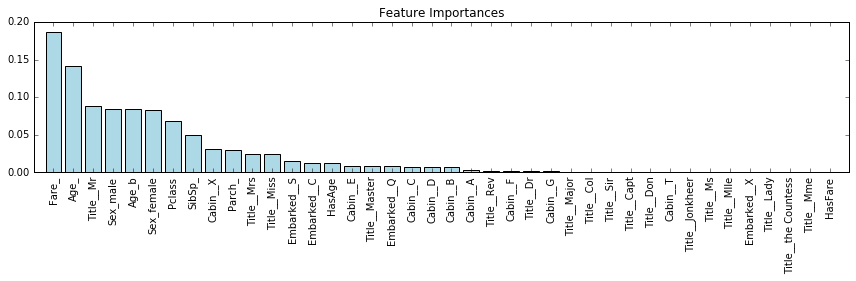

In [14]:
plt.figure(figsize=(12,4))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

In [15]:
np.unique(df_f[['Embarked_']])

array(['C', 'Q', 'S', 'X'], dtype=object)

In [18]:
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(forest, prefit=True, threshold=0.05)
X_new = model.transform(X_train)
X_new.shape

(891, 8)

array([[ 22.        ,   7.25      ],
       [ 38.        ,  40.        ],
       [ 26.        ,   7.925     ],
       ..., 
       [ 29.69911765,  23.45      ],
       [ 26.        ,  30.        ],
       [ 32.        ,   7.75      ]])